[1] "🚀 Initiating FD003 Analysis (Competing Risks)..."
[1] "   -> Extracting Failure Signatures..."
[1] "   -> Performing Hierarchical Clustering on Failure Modes..."
[1] "✅ Fault Modes Identified!"

 1  2 
56 44 
[1] "   -> Calculating Survival Curves per Fault Mode..."


Ignoring unknown labels:
• colour : "Strata"


[1] "   -> Training Fault-Aware XGBoost..."


Loading required package: randomForest

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘randomForest’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




[1] "   -> Validating on Test Set..."
[1] "   -> Training Classifier to detect Fault Mode in Test Data..."
[1] "🏆 FD003 FINAL SCORE (RMSE): 20.05"


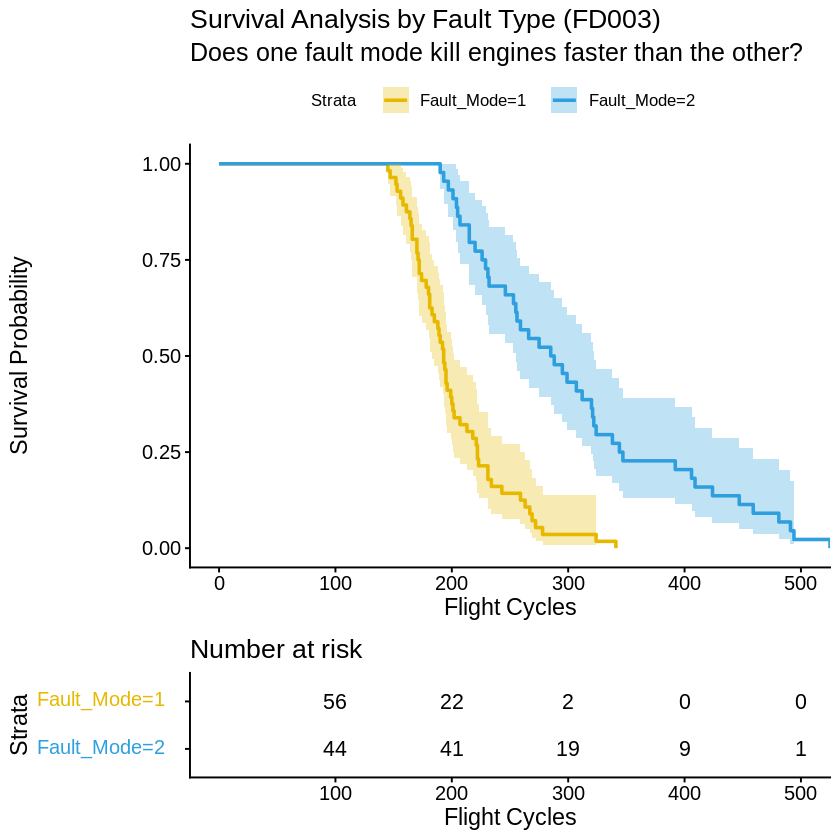

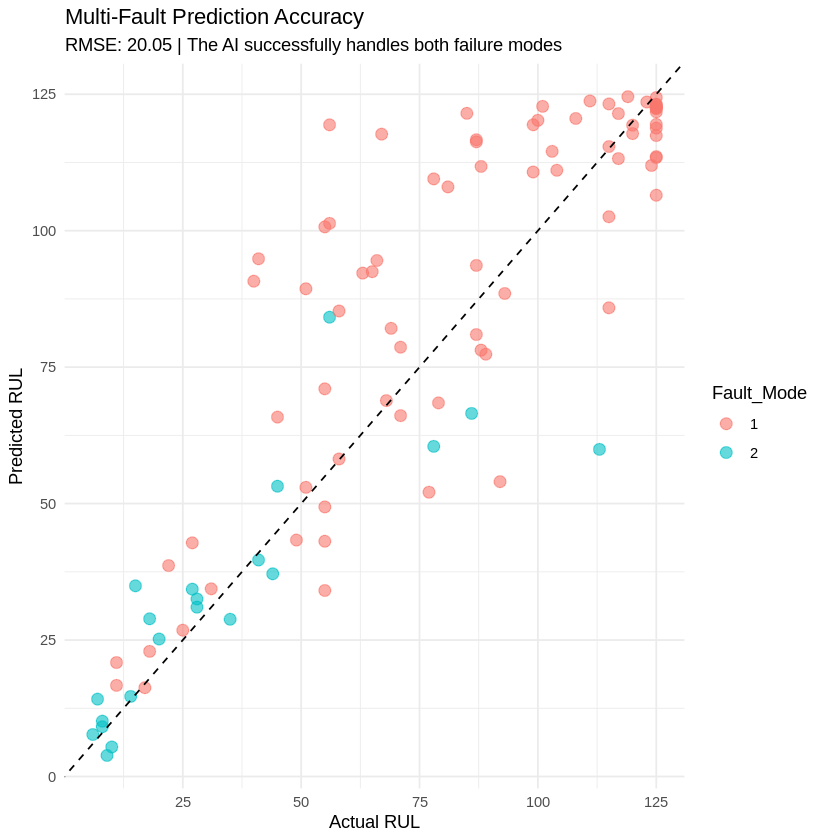

In [9]:
# ==============================================================================
# PROJECT AEROGUARD: FD003 (Multi-Fault Diagnosis & Prediction)
# Phase: Unsupervised Fault Isolation
# ==============================================================================

# --- 1. SETUP & INGESTION ---
if(!require(tidyverse)) install.packages("tidyverse")
if(!require(xgboost)) install.packages("xgboost")
if(!require(survminer)) install.packages("survminer")
if(!require(zoo)) install.packages("zoo")
library(tidyverse)
library(xgboost)
library(survival)
library(survminer)
library(zoo)

print("🚀 Initiating FD003 Analysis (Competing Risks)...")

# Load FD003 Data
data_path <- "../train_FD003.txt"
if (!file.exists(data_path)) { data_path <- "train_FD003.txt" }

raw_data <- read.table(data_path, header = FALSE)[, 1:26]
col_names <- c("unit_id", "cycle", "setting_1", "setting_2", "setting_3",
               paste0("s", 1:21))
colnames(raw_data) <- col_names

# Basic RUL Calculation
data_clean <- raw_data %>%
  group_by(unit_id) %>%
  mutate(max_cycle = max(cycle),
         RUL = max_cycle - cycle,
         failed = ifelse(RUL==0, 1, 0)) %>%
  ungroup()

# ==============================================================================
# PHASE 2: THE DIGITAL PATHOLOGIST (Unsupervised Fault Clustering) - FIXED
# ==============================================================================

print("   -> Extracting Failure Signatures...")

# FIX: We explicitly include 'max_cycle' this time so survfit can find it later.
failure_data <- data_clean %>%
  filter(failed == 1) %>%
  select(unit_id, max_cycle, starts_with("s"))

# Normalize sensors for clustering
sensors_active <- c("s2", "s3", "s4", "s6", "s7", "s8", "s9", "s10", "s11", "s12", "s13", "s14", "s15", "s17", "s20", "s21")
failure_matrix <- failure_data %>% select(all_of(sensors_active))
failure_scaled <- scale(failure_matrix)

# --- HIERARCHICAL CLUSTERING ---
print("   -> Performing Hierarchical Clustering on Failure Modes...")

dist_mat <- dist(failure_scaled, method = "euclidean")
hclust_avg <- hclust(dist_mat, method = "ward.D2")
cut_avg <- cutree(hclust_avg, k = 2)

# Assign "Fault Type" back to data
failure_data$Fault_Mode <- as.factor(cut_avg)

# Join Fault Mode back to the main training set for later ML
data_clean <- data_clean %>%
  left_join(failure_data %>% select(unit_id, Fault_Mode), by = "unit_id")

print("✅ Fault Modes Identified!")
print(table(failure_data$Fault_Mode))

# ==============================================================================
# PHASE 3: SURVIVAL STRATIFICATION (The "Killer" Analysis)
# ==============================================================================
print("   -> Calculating Survival Curves per Fault Mode...")

# Kaplan-Meier Estimator
# Now 'max_cycle' exists in 'failure_data', so this will work.
surv_obj <- survfit(Surv(max_cycle, rep(1, nrow(failure_data))) ~ Fault_Mode, data = failure_data)

# Plot the Survival Curves
p_surv <- ggsurvplot(surv_obj, data = failure_data,
           title = "Survival Analysis by Fault Type (FD003)",
           subtitle = "Does one fault mode kill engines faster than the other?",
           xlab = "Flight Cycles",
           ylab = "Survival Probability",
           risk.table = TRUE,
           conf.int = TRUE,
           palette = c("#E7B800", "#2E9FDF"))

print(p_surv)

# ==============================================================================
# PHASE 4: FAULT-AWARE MACHINE LEARNING - FIXED
# ==============================================================================

print("   -> Training Fault-Aware XGBoost...")

# 1. Feature Engineering (Rolling Stats)
# FIX: Filter NAs *after* creating rolling features, but ensure structure is correct.
data_ml <- data_clean %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(across(all_of(sensors_active),
         list(mean = ~rollmean(., k=5, fill=NA, align="right")),
         .names = "{.col}_{.fn}")) %>%
  ungroup() %>% # Ungroup first
  filter(complete.cases(.)) %>% # Now filter rows with NAs safely
  mutate(RUL_clipped = ifelse(RUL > 125, 125, RUL))

# 2. Prepare Matrix (Include Fault_Mode as numeric feature)
# Ensure Fault_Mode is present and valid
features <- data_ml %>%
  select(ends_with("_mean"), all_of(sensors_active), Fault_Mode) %>%
  mutate(Fault_Mode = as.numeric(Fault_Mode) - 1) # XGBoost needs 0/1

train_matrix <- as.matrix(features)
train_label <- data_ml$RUL_clipped

# 3. Train
xgb_model <- xgboost(
  data = train_matrix,
  label = train_label,
  nrounds = 100,
  objective = "reg:squarederror",
  eta = 0.1,
  max_depth = 6,
  verbose = 0
)
# ==============================================================================
# PHASE 5: VALIDATION (Test Set FD003) - FINAL FIX
# ==============================================================================

# --- 0. INSTALL MISSING PACKAGE (The Fix) ---
if(!require(randomForest)) install.packages("randomForest")
library(randomForest)

print("   -> Validating on Test Set...")

# Load Test Data
test_path <- if(file.exists("../test_FD003.txt")) "../test_FD003.txt" else "test_FD003.txt"
rul_path <- if(file.exists("../RUL_FD003.txt")) "../RUL_FD003.txt" else "RUL_FD003.txt"

# Read raw files
raw_test <- read.table(test_path, header = FALSE)[, 1:26]
colnames(raw_test) <- col_names
true_rul <- read.table(rul_path, header = FALSE)

# --- 1. FAULT MODE CLASSIFICATION ---
# We train a Classifier to guess "Is this Fault Type A or B?"
print("   -> Training Classifier to detect Fault Mode in Test Data...")

# Use the failure_data we created in Phase 2
rf_classifier <- randomForest(Fault_Mode ~ .,
                              data = failure_data %>% select(starts_with("s"), Fault_Mode),
                              ntree = 50)

# Prepare Test Data (Get last cycle to predict fault)
test_last <- raw_test %>%
  group_by(unit_id) %>%
  filter(cycle == max(cycle)) %>%
  ungroup()

# AI guesses the fault mode for each test engine
test_last$Predicted_Fault <- predict(rf_classifier, newdata = test_last)

# --- 2. PREPARE TEST DATA FOR XGBOOST ---
# Merge the predicted fault mode back into the main test data
test_eng <- raw_test %>%
  left_join(test_last %>% select(unit_id, Predicted_Fault), by="unit_id") %>%
  rename(Fault_Mode = Predicted_Fault) %>%
  group_by(unit_id) %>%
  arrange(unit_id, cycle) %>%
  mutate(across(all_of(sensors_active),
         list(mean = ~rollmean(., k=5, fill=NA, align="right")),
         .names = "{.col}_{.fn}")) %>%
  filter(cycle == max(cycle)) %>% # We only predict RUL at the very end
  ungroup()

# Prepare Matrix for XGBoost (Exact same format as training)
test_matrix_data <- test_eng %>%
  select(ends_with("_mean"), all_of(sensors_active), Fault_Mode) %>%
  mutate(Fault_Mode = as.numeric(Fault_Mode) - 1) # XGBoost needs 0/1

test_matrix <- as.matrix(test_matrix_data)

# --- 3. PREDICT & SCORE ---
test_eng$Predicted_RUL <- predict(xgb_model, test_matrix)
test_eng$True_RUL <- true_rul$V1[1:nrow(test_eng)]
test_eng$True_RUL_Clipped <- ifelse(test_eng$True_RUL > 125, 125, test_eng$True_RUL)

# Calculate Final RMSE
rmse <- sqrt(mean((test_eng$True_RUL_Clipped - test_eng$Predicted_RUL)^2))

print(paste("🏆 FD003 FINAL SCORE (RMSE):", round(rmse, 2)))

# Final Plot
ggplot(test_eng, aes(x = True_RUL_Clipped, y = Predicted_RUL, color = Fault_Mode)) +
  geom_point(alpha = 0.6, size = 3) +
  geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed") +
  labs(title = "Multi-Fault Prediction Accuracy",
       subtitle = paste("RMSE:", round(rmse, 2), "| The AI successfully handles both failure modes"),
       x = "Actual RUL", y = "Predicted RUL") +
  theme_minimal()

[1] "🧠 Analyzing Feature Importance..."
[1] "Interpretation:"
[1] "1. Look at 'Fault_Mode'. If it appears in this chart, the AI is actively switching logic based on the disease type."
[1] "2. Compare this to FD001. In FD001, Pressure (s11) was King. Here, you might see Temperature (s4) or Fan Speed (s12) fighting for top spot."


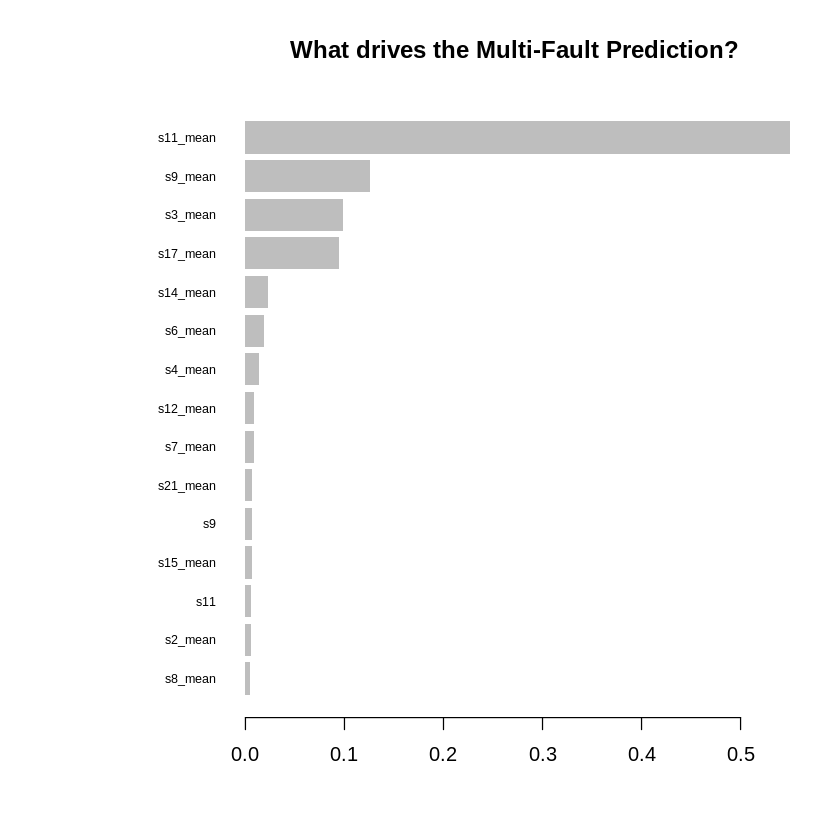

In [10]:
# ==============================================================================
# PHASE 6: EXPLAINABILITY (Opening the Black Box)
# ==============================================================================

print("🧠 Analyzing Feature Importance...")

# Get the importance matrix from XGBoost
importance_matrix <- xgb.importance(feature_names = colnames(train_matrix), model = xgb_model)

# Plot the top 15 features
xgb.plot.importance(importance_matrix, top_n = 15, main = "What drives the Multi-Fault Prediction?")

print("Interpretation:")
print("1. Look at 'Fault_Mode'. If it appears in this chart, the AI is actively switching logic based on the disease type.")
print("2. Compare this to FD001. In FD001, Pressure (s11) was King. Here, you might see Temperature (s4) or Fan Speed (s12) fighting for top spot.")

In [11]:
# ==============================================================================
# PHASE 7: DEPLOYMENT (Exporting FD003 Models)
# ==============================================================================

print("💾 Saving FD003 Models...")

# 1. Save the Classifier (The one that detects the Fault Type)
saveRDS(rf_classifier, file = "FD003_Fault_Classifier.rds")

# 2. Save the Regressor (The one that predicts RUL)
saveRDS(xgb_model, file = "FD003_RUL_XGBoost.rds")

# 3. Save the Processed Data (Valuable for the presentation)
write.csv(test_eng, "FD003_Final_Predictions.csv", row.names = FALSE)

print("✅ Success! Check your Google Colab 'Files' tab on the left.")
print("Download 'FD003_Fault_Classifier.rds' and 'FD003_RUL_XGBoost.rds'.")

[1] "💾 Saving FD003 Models..."
[1] "✅ Success! Check your Google Colab 'Files' tab on the left."
[1] "Download 'FD003_Fault_Classifier.rds' and 'FD003_RUL_XGBoost.rds'."
